In [109]:
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

from arch import arch_model 
from tqdm import tqdm

# Загрузка данных

In [207]:
# https://bonds.finam.ru/issue/details018F500002/default.asp -- пример источника данных

bonds_file_names = ['\SU26205RMFS3_rates.csv', 
                 '\SU26209RMFS5_rates.csv',
                 '\SU26212RMFS9_rates.csv',
                 '\SU26215RMFS2_rates.csv', 
                 '\SU26217RMFS8_rates.csv']

bonds_names = [x[1:len('SU26209RMFS5')+1] for x in bonds_file_names]

shares_file_names = ["\SBER.ME.csv", 
                  '\GAZP.ME.csv', 
                  '\YNDX.ME.csv',
                  '\MGNT.ME.csv', 
                  '\GMKN.ME.csv',
                  '\MTSS.ME.csv', 
                  '\PIKK.ME.csv', 
                  '\AFLT.ME.csv', 
                  '\POLY.ME.csv', 
                  '\RSTI.ME.csv']

shares_names = [x[1:5] for x in shares_file_names]

currencies_file_names = ['\D_USD.csv',
                      '\D_CNY.csv']

currencies_names = [x[3:6] for x in currencies_file_names]

risks_file_names = ['\IMOEX.ME.csv',
                    '\BZ=F.csv',
                    '\RTS.csv']   

risks_names = [x.split(chr(92))[1].split('.csv')[0] for x in risks_file_names]

bonds_folder = 'bonds'
shares_folder = 'shares'
currencies_folder = 'currencies'
risks_folder = 'risk_factors'

bonds = [bonds_folder + x for x in bonds_file_names]
shares = [shares_folder + x for x in shares_file_names]
currencies = [currencies_folder + x for x in currencies_file_names]
risks = [risks_folder + x for x in risks_file_names]
zero_bonds = risks_folder + '/zero_bonds.csv'
metals = risks_folder + '/refined_precious_metals.xlsx'

In [208]:
def load_df(bonds=bonds, bonds_names=bonds_names, 
            shares=shares, shares_names=shares_names,
            currencies=currencies, currencies_names=currencies_names,
            risks=risks, risks_names=risks_names,
            zero_bonds=zero_bonds, metals=metals):
#     Основной df
    main_df = pd.read_csv(bonds[0], index_col='<DATE>')
    main_df.index = pd.to_datetime(main_df.index, format='%Y%m%d')
    main_df = main_df[[]]
    main_df.index.names = ['Date']
#     Загрузка облигаций
    for i in range(len(bonds)):
        df = pd.read_csv(bonds[i], index_col='<DATE>')
        df.index = pd.to_datetime(df.index, format='%Y%m%d')
        df = df[['<CLOSE>']].rename(columns={'<CLOSE>': bonds_names[i]})
        df.index.names = ['Date']
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка акций
    for i in range(len(shares)):
        df = pd.read_csv(shares[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': shares_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка валют
    for i in range(len(currencies)):
        df = pd.read_csv(currencies[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': currencies_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка рисков
    for i in range(len(risks)):
        df = pd.read_csv(risks[i], index_col='Date')
        df.index = pd.to_datetime(df.index)
        df = df[['Adj Close']].rename(columns={'Adj Close': risks_names[i]})
        main_df = main_df.join(df, how='left', on='Date')
#     Загрузка металлов
    df = pd.read_excel(metals, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Загрузка zero_bonds
    df = pd.read_csv(zero_bonds, index_col='Date')
    df.index = pd.to_datetime(df.index)
    main_df = main_df.join(df, how='left', on='Date')

#     Заполнение пропусков
    main_df.fillna(method='ffill', inplace=True)
    main_df.fillna(method='backfill', inplace=True)

    return main_df

Портфель и риски в отдельных датафремах

In [209]:
prices = load_df()

bonds = prices.iloc[:, 0:5]
shares = prices.iloc[:, 5:15]
currencies = prices.iloc[:, 15:17]
risk_factors = prices.iloc[:, 17:]

ret = prices.pct_change()
ret.dropna(inplace=True)

bonds_ret = ret.iloc[:, 0:5]
shares_ret = ret.iloc[:, 5:15]
currencies_ret = ret.iloc[:, 15:17]
risk_factors_ret = ret.iloc[:, 17:]

# Составляем портфель

In [306]:
position_0 = np.array([10e6] * 5 + [1e6] * 10 + [10e6] * 2)
day_prices = prices.iloc[0, :17]
true_qty = position_0 / day_prices
qty = np.round(position_0 / day_prices, 0).astype(int)
portfolio_qty_shares_true = (true_qty * portfolio_prices) / (true_qty * portfolio_prices).sum()

In [307]:
portfolio_qty_shares_true

SU26205RMFS3    0.1250
SU26209RMFS5    0.1250
SU26212RMFS9    0.1250
SU26215RMFS2    0.1250
SU26217RMFS8    0.1250
SBER            0.0125
GAZP            0.0125
YNDX            0.0125
MGNT            0.0125
GMKN            0.0125
MTSS            0.0125
PIKK            0.0125
AFLT            0.0125
POLY            0.0125
RSTI            0.0125
USD             0.1250
CNY             0.1250
Name: 2017-01-03 00:00:00, dtype: float64

In [308]:
all_qty = qty
all_price = day_prices

In [309]:
for t in range(1, prices.shape[0]):
    day_prices = prices.iloc[t-1, :17]
    wts = (qty * day_prices) / np.sum(qty * day_prices)
    delta_wts = portfolio_qty_shares_true / wts
    qty = np.round(qty * delta_wts, 0).astype(int)
    all_qty = np.vstack((all_qty, qty))
    all_price = np.vstack((all_price, day_prices))

In [310]:
number_of_assets = pd.DataFrame(all_qty, columns=prices.iloc[:, :17].columns)
prices_of_assets = pd.DataFrame(all_price, columns=prices.iloc[:, :17].columns)

In [314]:
total_sum = pd.DataFrame(all_qty*all_price, columns=prices.iloc[:, :17].columns)

In [316]:
total_sum

,SU26205RMFS3,SU26209RMFS5,SU26212RMFS9,SU26215RMFS2,SU26217RMFS8,SBER,GAZP,YNDX,MGNT,GMKN,MTSS,PIKK,AFLT,POLY,RSTI,USD,CNY
0,1.000004e+07,1.000002e+07,9.999994e+06,1.000000e+07,9.999999e+06,9.999548e+05,9.999424e+05,1.000246e+06,1.000197e+06,9.975757e+05,1.000027e+06,9.999310e+05,9.999374e+05,9.996933e+05,1.000000e+06,9.999989e+06,9.999999e+06
1,9.999647e+06,9.999727e+06,9.999719e+06,9.999719e+06,9.999705e+06,9.999548e+05,9.999424e+05,1.000246e+06,1.000197e+06,9.975757e+05,1.000027e+06,9.999310e+05,9.999374e+05,9.996933e+05,9.999697e+05,9.999683e+06,9.999691e+06
2,9.996404e+06,9.996403e+06,9.996424e+06,9.996361e+06,9.996370e+06,9.996598e+05,9.996056e+05,9.994400e+05,9.976027e+05,9.996008e+05,9.997099e+05,9.996513e+05,9.995957e+05,9.994833e+05,9.996402e+05,9.996429e+06,9.996395e+06
3,9.973051e+06,9.973017e+06,9.973038e+06,9.973024e+06,9.973022e+06,9.973288e+05,9.972452e+05,9.978440e+05,1.000270e+06,9.964904e+05,9.973773e+05,9.971822e+05,9.973455e+05,9.973153e+05,9.973025e+05,9.973023e+06,9.973026e+06
4,9.945629e+06,9.945613e+06,9.945609e+06,9.945586e+06,9.945598e+06,9.945684e+05,9.945077e+05,9.940700e+05,9.942148e+05,9.911925e+05,9.945873e+05,9.945176e+05,9.945809e+05,9.944850e+05,9.945599e+05,9.945602e+06,9.945603e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,1.241323e+07,1.241327e+07,1.241325e+07,1.241328e+07,1.241323e+07,1.241220e+06,1.241396e+06,1.241244e+06,1.242241e+06,1.237020e+06,1.241449e+06,1.241170e+06,1.241309e+06,1.241219e+06,1.241328e+06,1.241328e+07,1.241327e+07
1004,1.236610e+07,1.236616e+07,1.236610e+07,1.236615e+07,1.236613e+07,1.236710e+06,1.236584e+06,1.235000e+06,1.238162e+06,1.231190e+06,1.236714e+06,1.236794e+06,1.236588e+06,1.237071e+06,1.236612e+06,1.236611e+07,1.236613e+07
1005,1.233874e+07,1.233876e+07,1.233875e+07,1.233870e+07,1.233874e+07,1.233851e+06,1.233787e+06,1.231712e+06,1.234243e+06,1.238186e+06,1.233846e+06,1.233874e+06,1.233875e+06,1.233646e+06,1.233873e+06,1.233873e+07,1.233872e+07
1006,1.235627e+07,1.235621e+07,1.235618e+07,1.235624e+07,1.235624e+07,1.235660e+06,1.235666e+06,1.233198e+06,1.233744e+06,1.229072e+06,1.235667e+06,1.235852e+06,1.235624e+06,1.235177e+06,1.235623e+06,1.235624e+07,1.235623e+07


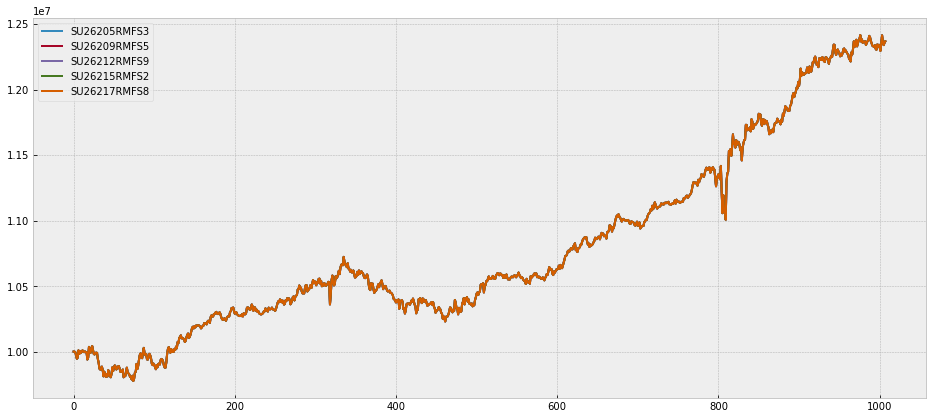

In [317]:
total_sum.iloc[:, :5].plot(figsize=(16, 7))

plt.show()